In [24]:
!pip install xgboost

In [25]:
!pip install shap

In [26]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [27]:
# Load the dataset
file_path = "C:\\Users\\manin\\Downloads\\data.csv"  
data = pd.read_csv(file_path)

# Check the first few rows
print(data.head())

# Get dataset info
print(data.info())

   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.4577

In [28]:
# Display dataset information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [29]:
print(data.isnull().sum()) 
print(data.describe())

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64
         Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  6819.000000                                        6819.000000          
mean      0.032263                                           0.505180          
std       0.176710                                   

In [30]:
from sklearn.model_selection import train_test_split

# Define features and target
X = data.drop(columns=["Bankrupt?"])  # Replace with the target column name
y = data["Bankrupt?"]

# Split into train, test, and OOS
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_oos, y_test, y_oos = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [31]:
# Separate features and target
X = data.drop(columns=["Bankrupt?"])
y = data["Bankrupt?"]

In [32]:
# Handle missing values
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [33]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [34]:
# Split into Train, Test, and OOS (Out of Sample)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)
X_test, X_oos, y_test, y_oos = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [35]:
# Feature Scaling (for Logistic Regression or models requiring scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_oos_scaled = scaler.transform(X_oos)
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

Step 2: Exploratory Data Analysis (EDA)

In [36]:
# Correlation Matrix
correlation_matrix = pd.DataFrame(X_train, columns=X.columns).corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                                                    ROA(C) before interest and depreciation before interest  \
ROA(C) before interest and depreciation before ...                                           1.000000         
ROA(A) before interest and % after tax                                                       0.945089         
ROA(B) before interest and depreciation after tax                                            0.989340         
Operating Gross Margin                                                                       0.379171         
Realized Sales Gross Margin                                                                  0.376919         
...                                                                                               ...         
Liability to Equity                                                                         -0.201186         
Degree of Financial Leverage (DFL)                                                          

In [37]:
# Variance Inflation Factor (VIF) to detect multicollinearity
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
print("VIF Data:")
print(vif_data)

C:\Users\manin\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


VIF Data:
                                              Feature           VIF
0    ROA(C) before interest and depreciation befor...  1.533454e+02
1              ROA(A) before interest and % after tax  9.272014e+01
2    ROA(B) before interest and depreciation after...  3.031113e+02
3                              Operating Gross Margin  1.012801e+07
4                         Realized Sales Gross Margin  1.416319e+03
..                                                ...           ...
90                                Liability to Equity  2.174831e+03
91                 Degree of Financial Leverage (DFL)  1.026795e+00
92   Interest Coverage Ratio (Interest expense to ...  1.028332e+00
93                                    Net Income Flag  0.000000e+00
94                                Equity to Liability  7.636985e+00

[95 rows x 2 columns]


array([[<Axes: title={'center': ' ROA(C) before interest and depreciation before interest'}>,
        <Axes: title={'center': ' ROA(A) before interest and % after tax'}>,
        <Axes: title={'center': ' ROA(B) before interest and depreciation after tax'}>,
        <Axes: title={'center': ' Operating Gross Margin'}>,
        <Axes: title={'center': ' Realized Sales Gross Margin'}>,
        <Axes: title={'center': ' Operating Profit Rate'}>,
        <Axes: title={'center': ' Pre-tax net Interest Rate'}>,
        <Axes: title={'center': ' After-tax net Interest Rate'}>,
        <Axes: title={'center': ' Non-industry income and expenditure/revenue'}>,
        <Axes: title={'center': ' Continuous interest rate (after tax)'}>],
       [<Axes: title={'center': ' Operating Expense Rate'}>,
        <Axes: title={'center': ' Research and development expense rate'}>,
        <Axes: title={'center': ' Cash flow rate'}>,
        <Axes: title={'center': ' Interest-bearing debt interest rate'}>,
  

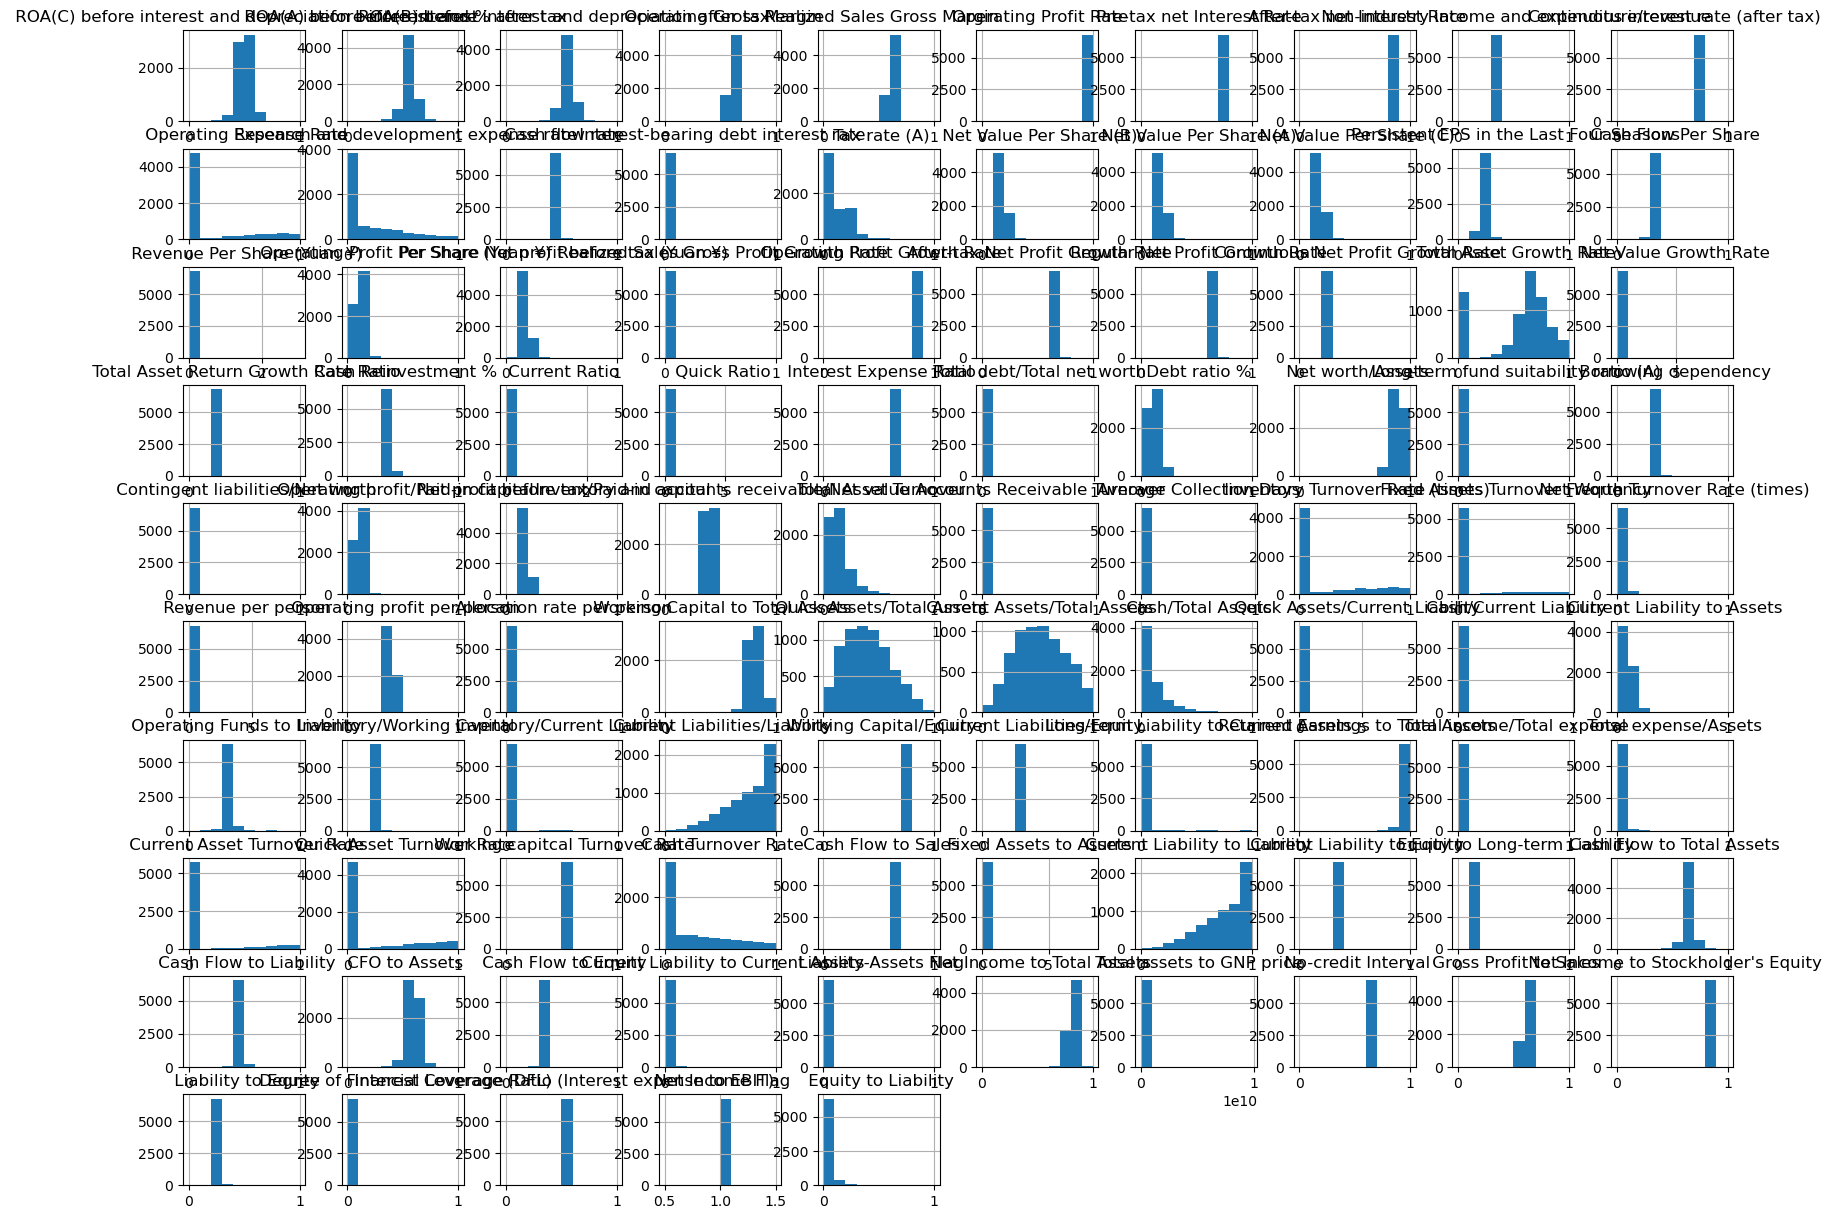

In [38]:
# Visualize feature distributions (histograms)
X.hist(figsize=(20, 15))

Step 3: Feature Selection

In [39]:
# Using RandomForest to select important features
selector = SelectFromModel(RandomForestClassifier(random_state=42), threshold="mean")
selector.fit(X_train, y_train)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
X_oos_selected = selector.transform(X_oos)

Selected Features: Index([' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Pre-tax net Interest Rate', ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)',
       ' Interest-bearing debt interest rate',
       ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (Yuan ¥)', ' Net Value Growth Rate',
       ' Interest Expense Ratio', ' Total debt/Total net worth',
       ' Debt ratio %', ' Net worth/Assets', ' Borrowing dependency',
       ' Net profit before tax/Paid-in capital',
       ' Retained Earnings to Total Assets', ' Total income/Total expense',
       ' Current Liability to Equity', ' Net Income to Total Assets',
       ' Net Income to Stockholder's Equity', ' Liability to Equity'],
      dtype='object')


Step 4: Train Models
Model 1: Random Forest

In [40]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

Model 2: XGBoost

In [41]:
xgb_model = XGBClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [42]:
Model 3: CatBoost

SyntaxError: invalid syntax (2294966935.py, line 1)

In [ ]:
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
param_grid = {
    'iterations': [50, 100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

Step 5: Evaluate Models Define a function to calculate PSI

In [ ]:
# Define the evaluation function
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    metrics = {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1-Score": f1_score(y, y_pred),
        "ROC-AUC": roc_auc_score(y, y_pred),
        "Confusion Matrix": confusion_matrix(y, y_pred)
    }
    return metrics

# Load the saved model
best_model = joblib.load("best_model.joblib")

# Get the evaluation metrics
metrics = evaluate_model(best_model, X_test, y_test)

# Print the metrics
for metric, value in metrics.items():
    print(f"{metric}: {value}")

In [ ]:
# Save the Best Model
joblib.dump(best_xgb_model, "best_model.joblib")

In [ ]:
# Save the models as pickle files
import pickle
with open("best_xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb_model, f)

with open("best_cat_model.pkl", "wb") as f:
    pickle.dump(best_cat_model, f)

with open("best_rf_model.pkl", "wb") as f:
    pickle.dump(best_rf_model, f)

print("Models saved as pickle files.")

Step 5: Evaluate Models
Define a function to calculate PSI

In [ ]:
def calculate_psi(expected, actual, buckets=10):
    breakpoints = np.linspace(0, 1, buckets + 1)
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)

In [ ]:
# PSI for important features
psi_results = {"Train-Test": {}, "Train-OOS": {}, "Test-OOS": {}}
for feature in selected_features:
    psi_results["Train-Test"][feature] = calculate_psi(X_train[feature], X_test[feature])
    psi_results["Train-OOS"][feature] = calculate_psi(X_train[feature], X_oos[feature])
    psi_results["Test-OOS"][feature] = calculate_psi(X_test[feature], X_oos[feature])

In [ ]:
print("PSI Results:", psi_results)

In [ ]:
pip install --upgrade shap

In [ ]:
import shap

Step 6: Explainability with SHAP

In [ ]:
# Step 6: Explainability with SHAP
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_selected)

In [ ]:
# Visualize SHAP values
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

app = FastAPI()

In [ ]:
# Load the Best Model
joblib.dump(best_xgb_model, "best_model.joblib")

In [ ]:
# Define the input structure
class PredictionRequest(BaseModel):
    features: list

# Prediction endpoint
@app.post("/predict/")
async def predict(request: PredictionRequest):
    input_data = np.array(request.features).reshape(1, -1)
    prediction = model.predict(input_data)
    return {"prediction": prediction[0]}


In [3]:
pip install fastapi uvicorn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [4]:
from fastapi import FastAPI
from pydantic import BaseModel
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np





In [ ]:
# Load the trained model and scaler
model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")